In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display, Markdown

## Important

$$
CVaR_w (\alpha) = -E[r_w \ | \ r_w \leq -VaR_w (\alpha)]
$$


$$
C_{(i)}CVaR_w (\alpha) = -E[w_{(i)}r_{(i)} \ | \ r_w \leq -VaR_w (\alpha)]
$$


$$
\%C_{(i)}CVaR_w(\alpha) = \frac{E[w_{(i)}r_{(i)} \ | \ r_w \leq -VaR_w(\alpha)]}{E[r_w \ | \ r_w \leq -VaR_w(\alpha)]}
$$

MCC portfolio:

$$
w^{MCC} = argmin \ C_w (\alpha)
$$

$$
s.t. \ \ \sum_{i=1}^{n} w_i = 1
$$

$$
\quad 0 \leq w_i \leq 1
$$


where

$$
C_w(\alpha) = max_i \ C_{(i)}CVaR_w (\alpha)
$$

$$
w_i: \text{peso del activo i}
$$

The other two strategies are the minimum CVaR (MC) and equal-weight (EW) portfolios:

$$
w^{minCVaR} = argmin_{w \in W}CVaR_w (\alpha) \ \text{and} \ w^{EW} = (1/N, ... , 1/N)'
$$

$$
r_p = \sum_{i=1}^{n} w_i r_i
$$

$$
VaR_w (\alpha) = -P_\alpha
$$

## Download data

In [2]:
# bonds, commodities, equities and real estate
tickers = ['VBTLX', 'GSG', 'VTI', 'VNQ']
start_date = '2019-01-01'
end_date = '2024-01-01'

data = yf.download(tickers, start_date, end_date)['Adj Close']

# calculate returns
returns = data.pct_change().dropna()

# defining alpha and the number of assets
alpha = 0.05
n_assets = len(returns.columns)

[*********************100%***********************]  4 of 4 completed


**Assets selected:**

- VBTLX (Vanguard Total Bond Market Index Fund Admiral Shares) – A mutual fund that tracks the performance of the U.S. bond market, providing broad exposure to investment-grade bonds.

- GSG (iShares S&P GSCI Commodity-Indexed Trust) – An ETF that tracks the performance of a broad commodities index, including energy, metals, and agricultural products.

- VTI (Vanguard Total Stock Market ETF) – An ETF that provides exposure to the entire U.S. stock market, including small-, mid-, and large-cap stocks.

- VNQ (Vanguard Real Estate ETF) – An ETF that invests in U.S. real estate investment trusts (REITs), offering exposure to the real estate sector.

## Calculate CVaR

In [3]:
# CVaR for only long positions
def portfolio_return(returns, weights):
    return np.dot(returns, weights)

# Better way to calculate CVaR than the one used in my homework 1. I used .query in the homework, but checking with friends this way is better.
def cvar(portfolio_returns, alpha):
    var = np.percentile(portfolio_returns, alpha*100)
    cvar = -portfolio_returns[portfolio_returns < var].mean()
    return cvar

def individual_cvar_contributions(weights, returns, alpha):
    portfolio_returns = portfolio_return(returns, weights)
    var = np.percentile(portfolio_returns, alpha*100)

    # check which days are in the cvar for the portfolio
    bad_days_portfolio = portfolio_returns < var

    contributions = []
    # chech the returns of each asset the days where the portfolio is in the cvar to know the contribution
    for i in range(n_assets):
        asset_contribution = -returns.iloc[:, i][bad_days_portfolio].mean() * weights[i]
        contributions.append(asset_contribution)
    
    portfolio_cvar = cvar(portfolio_returns, alpha)

    percentage_contributions = []
    for j in range(len(contributions)):
        pct_contributions = contributions[j] / portfolio_cvar
        percentage_contributions.append(pct_contributions)
    
    return contributions

## Optimization

In [4]:
def optimal_mcc(weights, returns, alpha):
    cvar_contributions = individual_cvar_contributions(weights, returns, alpha)
    return np.max(cvar_contributions)

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
]
bounds = tuple((0, 1) for _ in range(n_assets))

# Initial guess
initial_weights = np.ones(n_assets) / n_assets

result = minimize(
    fun=optimal_mcc,
    x0=initial_weights,
    args=(returns, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
mcc_weights = result.x



def min_cvar(weights, returns, alpha):
    portfolio_returns = portfolio_return(returns, weights)
    return cvar(portfolio_returns, alpha)

result_min_cvar = minimize(
    fun=min_cvar,
    x0=initial_weights,
    args=(returns, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
min_cvar_weights = result_min_cvar.x


## Weights and Contributions

In [5]:
mcc_cvar_contrubutions = individual_cvar_contributions(mcc_weights, returns, alpha)
mcc_cvar = cvar(portfolio_return(returns, mcc_weights), alpha)
mcc_cvar_pct_contributions = mcc_cvar_contrubutions / mcc_cvar

min_cvar_cvar_contrubutions = individual_cvar_contributions(min_cvar_weights, returns, alpha)
min_cvar_cvar = cvar(portfolio_return(returns, min_cvar_weights), alpha)
min_cvar_cvar_pct_contributions = min_cvar_cvar_contrubutions / min_cvar_cvar

ew_weights = np.ones(n_assets) / n_assets
ew_cvar_contrubutions = individual_cvar_contributions(ew_weights, returns, alpha)
ew_cvar = cvar(portfolio_return(returns, ew_weights), alpha)
ew_cvar_pct_contributions = ew_cvar_contrubutions / ew_cvar

In [6]:
print(f'MCC Portfolio weights:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {mcc_weights[i]:.4%}')
print('---------------------')

print()

print(f'MCC Portfolio CVaR percentage contribution:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {mcc_cvar_pct_contributions[i]:.4%}')
print('---------------------')

print()
print()

print(f'Min CVaR Portfolio weights:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {min_cvar_weights[i]:.4%}')
print('---------------------')

print()

print(f'Min CVaR Portfolio CVaR percentage contribution:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {min_cvar_cvar_pct_contributions[i]:.4%}')
print('---------------------')

print()
print()

print(f'Equal-Weight Portfolio weights:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {ew_weights[i]:.4%}')
print('---------------------')

print()

print(f'Equal-Weight Portfolio CVaR percentage contribution:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {ew_cvar_pct_contributions[i]:.4%}')
print('---------------------')

MCC Portfolio weights:
---------------------
GSG: 12.0933%
VBTLX: 66.0134%
VNQ: 10.1814%
VTI: 11.7119%
---------------------

MCC Portfolio CVaR percentage contribution:
---------------------
GSG: 25.5172%
VBTLX: 25.3816%
VNQ: 25.5060%
VTI: 23.5952%
---------------------


Min CVaR Portfolio weights:
---------------------
GSG: 3.7399%
VBTLX: 95.6289%
VNQ: 0.0000%
VTI: 0.6311%
---------------------

Min CVaR Portfolio CVaR percentage contribution:
---------------------
GSG: 3.7522%
VBTLX: 95.6145%
VNQ: 0.0000%
VTI: 0.6333%
---------------------


Equal-Weight Portfolio weights:
---------------------
GSG: 25.0000%
VBTLX: 25.0000%
VNQ: 25.0000%
VTI: 25.0000%
---------------------

Equal-Weight Portfolio CVaR percentage contribution:
---------------------
GSG: 32.8778%
VBTLX: 0.7586%
VNQ: 35.4760%
VTI: 30.8876%
---------------------


## Static Backtesting

In [7]:
# bonds, commodities, equities and real estate
data = yf.download(tickers, end_date, end='2024-12-31')['Adj Close']

# calculate returns
returns = data.pct_change().dropna()

pd.options.display.float_format = '{:.4f}%'.format

[*********************100%***********************]  4 of 4 completed


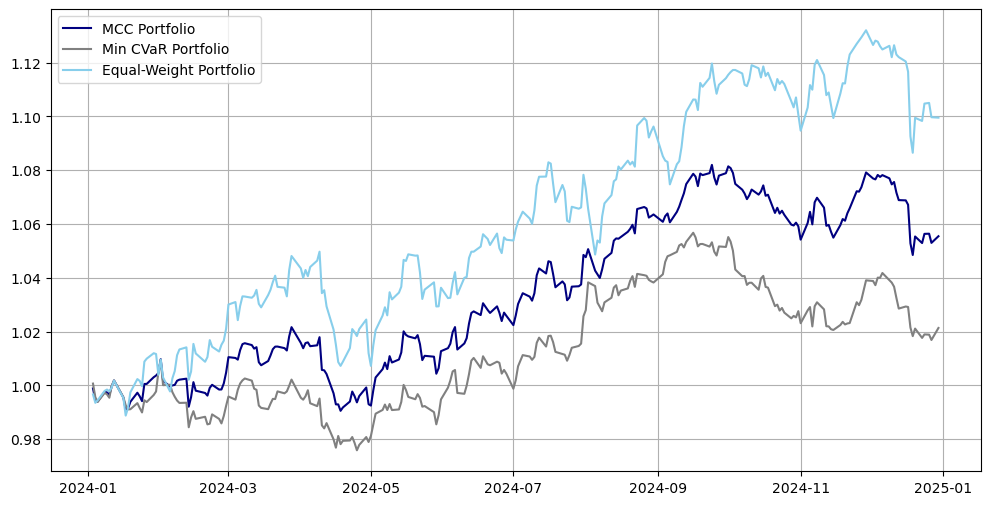

In [8]:
mcc_portfolio_returns = portfolio_return(returns, mcc_weights)
cumulative_return_mcc_port = (1 + mcc_portfolio_returns).cumprod()

min_cvar_portfolio_returns = portfolio_return(returns, min_cvar_weights)
cumulative_return_min_cvar_port = (1 + min_cvar_portfolio_returns).cumprod()

ew_portfolio_returns = portfolio_return(returns, ew_weights)
cumulative_return_ew_port = (1 + ew_portfolio_returns).cumprod()

cumulative_returns_df = pd.DataFrame({
    'MCC Portfolio': cumulative_return_mcc_port,
    'Min CVaR Portfolio': cumulative_return_min_cvar_port,
    'Equal-Weight Portfolio': cumulative_return_ew_port
})
cumulative_returns_df.index = returns.index

plt.figure(figsize=(12, 6))

plt.plot(cumulative_returns_df['MCC Portfolio'], label='MCC Portfolio', c = 'navy')
plt.plot(cumulative_returns_df['Min CVaR Portfolio'], label='Min CVaR Portfolio', c = 'gray')
plt.plot(cumulative_returns_df['Equal-Weight Portfolio'], label='Equal-Weight Portfolio', c = 'skyblue')

plt.legend()
plt.grid();

In [9]:
returns_df = pd.DataFrame({
    'MCC Portfolio': mcc_portfolio_returns,
    'Min CVaR Portfolio': min_cvar_portfolio_returns,
    'Equal-Weight Portfolio': ew_portfolio_returns
})

summary_df = pd.DataFrame({
    'Return (%)': (cumulative_returns_df.iloc[-1] - 1) * 100,
        'Annualized Volatility (%)': returns_df.std() * np.sqrt(252) * 100
})
summary_df

,Return (%),Annualized Volatility (%)
MCC Portfolio,5.5455%,5.4313%
Min CVaR Portfolio,2.1365%,5.1340%
Equal-Weight Portfolio,9.9529%,7.8967%


## Dynamic Backtesting

In [10]:
# bonds, commodities, equities and real estate
start_date = '2019-01-01'
q1 = '2024-01-01'
end_q1 = '2024-03-31'
end_q2 = '2024-06-30'
end_q3 = '2024-09-30'
end_q4 = '2024-12-31'

data = yf.download(tickers, start_date, q1)['Adj Close']
data_q1_train = yf.download(tickers, start_date, end_q1)['Adj Close']
data_q2_train = yf.download(tickers, start_date, end_q2)['Adj Close']
data_q3_train = yf.download(tickers, start_date, end_q3)['Adj Close']
data_q4_train = yf.download(tickers, start_date, end_q4)['Adj Close']

data_q1_test = yf.download(tickers, q1, end_q1)['Adj Close']
data_q2_test = yf.download(tickers, end_q1, end_q2)['Adj Close']
data_q3_test = yf.download(tickers, end_q2, end_q3)['Adj Close']
data_q4_test = yf.download(tickers, end_q3, end_q4)['Adj Close']


# calculate returns
returns = data.pct_change().dropna()
returns_q1_train = data_q1_train.pct_change().dropna()
returns_q2_train = data_q2_train.pct_change().dropna()
returns_q3_train = data_q3_train.pct_change().dropna()
returns_q4_train = data_q4_train.pct_change().dropna()

returns_q1_test = data_q1_test.pct_change().dropna()
returns_q2_test = data_q2_test.pct_change().dropna()
returns_q3_test = data_q3_test.pct_change().dropna()
returns_q4_test = data_q4_test.pct_change().dropna()

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


### Q1

In [11]:
def optimal_mcc(weights, returns, alpha):
    cvar_contributions = individual_cvar_contributions(weights, returns, alpha)
    return np.max(cvar_contributions)

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
]
bounds = tuple((0, 1) for _ in range(n_assets))

# Initial guess
initial_weights = np.ones(n_assets) / n_assets

result = minimize(
    fun=optimal_mcc,
    x0=initial_weights,
    args=(returns, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
mcc_weights_q1 = result.x



def min_cvar(weights, returns, alpha):
    portfolio_returns = portfolio_return(returns, weights)
    return cvar(portfolio_returns, alpha)

result_min_cvar = minimize(
    fun=min_cvar,
    x0=initial_weights,
    args=(returns, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
min_cvar_weights_q1 = result_min_cvar.x
mcc_weights_q1

array([0.12093323, 0.66013385, 0.10181387, 0.11711906])

In [12]:
mcc_portfolio_returns_q1 = portfolio_return(mcc_weights_q1, returns_q1_test.T)

min_cvar_portfolio_returns_q1 = portfolio_return(min_cvar_weights_q1, returns_q1_test.T)

ew_portfolio_returns_q1 = portfolio_return(ew_weights, returns_q1_test.T)


returns_df_q1 = pd.DataFrame({
    'MCC Portfolio': mcc_portfolio_returns_q1,
    'Min CVaR Portfolio': min_cvar_portfolio_returns_q1,
    'Equal-Weight Portfolio': ew_portfolio_returns_q1
})
returns_df_q1.index = returns_q1_test.index

### Q2

In [13]:
def optimal_mcc(weights, returns_q1_train, alpha):
    cvar_contributions = individual_cvar_contributions(weights, returns_q1_train, alpha)
    return np.max(cvar_contributions)

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
]
bounds = tuple((0, 1) for _ in range(n_assets))

# Initial guess
initial_weights = np.ones(n_assets) / n_assets

result = minimize(
    fun=optimal_mcc,
    x0=initial_weights,
    args=(returns_q1_train, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
mcc_weights_q2 = result.x



def min_cvar(weights, returns_q1_train, alpha):
    portfolio_returns = portfolio_return(returns_q1_train, weights)
    return cvar(portfolio_returns, alpha)

result_min_cvar = minimize(
    fun=min_cvar,
    x0=initial_weights,
    args=(returns_q1_train, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
min_cvar_weights_q2 = result_min_cvar.x
mcc_weights_q2

array([0.12430073, 0.64509672, 0.10330957, 0.12729298])

In [14]:
mcc_portfolio_returns_q2 = portfolio_return(mcc_weights_q2, returns_q2_test.T)

min_cvar_portfolio_returns_q2 = portfolio_return(min_cvar_weights_q2, returns_q2_test.T)

ew_portfolio_returns_q2 = portfolio_return(ew_weights, returns_q2_test.T)


returns_df_q2 = pd.DataFrame({
    'MCC Portfolio': mcc_portfolio_returns_q2,
    'Min CVaR Portfolio': min_cvar_portfolio_returns_q2,
    'Equal-Weight Portfolio': ew_portfolio_returns_q2
})
returns_df_q2.index = returns_q2_test.index

### Q3

In [15]:
def optimal_mcc(weights, returns_q2_train, alpha):
    cvar_contributions = individual_cvar_contributions(weights, returns_q2_train, alpha)
    return np.max(cvar_contributions)

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
]
bounds = tuple((0, 1) for _ in range(n_assets))

# Initial guess
initial_weights = np.ones(n_assets) / n_assets

result = minimize(
    fun=optimal_mcc,
    x0=initial_weights,
    args=(returns_q2_train, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
mcc_weights_q3 = result.x



def min_cvar(weights, returns_q2_train, alpha):
    portfolio_returns = portfolio_return(returns_q2_train, weights)
    return cvar(portfolio_returns, alpha)

result_min_cvar = minimize(
    fun=min_cvar,
    x0=initial_weights,
    args=(returns_q2_train, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
min_cvar_weights_q3 = result_min_cvar.x
mcc_weights_q3

array([0.25930517, 0.25930517, 0.22384081, 0.25754886])

In [16]:
mcc_portfolio_returns_q3 = portfolio_return(mcc_weights_q3, returns_q3_test.T)

min_cvar_portfolio_returns_q3 = portfolio_return(min_cvar_weights_q3, returns_q3_test.T)

ew_portfolio_returns_q3 = portfolio_return(ew_weights, returns_q3_test.T)


returns_df_q3 = pd.DataFrame({
    'MCC Portfolio': mcc_portfolio_returns_q3,
    'Min CVaR Portfolio': min_cvar_portfolio_returns_q3,
    'Equal-Weight Portfolio': ew_portfolio_returns_q3
})
returns_df_q3.index = returns_q3_test.index

### Q4

In [17]:
def optimal_mcc(weights, returns_q3_train, alpha):
    cvar_contributions = individual_cvar_contributions(weights, returns_q3_train, alpha)
    return np.max(cvar_contributions)

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
]
bounds = tuple((0, 1) for _ in range(n_assets))

# Initial guess
initial_weights = np.ones(n_assets) / n_assets

result = minimize(
    fun=optimal_mcc,
    x0=initial_weights,
    args=(returns_q3_train, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
mcc_weights_q4 = result.x



def min_cvar(weights, returns_q3_train, alpha):
    portfolio_returns = portfolio_return(returns_q3_train, weights)
    return cvar(portfolio_returns, alpha)

result_min_cvar = minimize(
    fun=min_cvar,
    x0=initial_weights,
    args=(returns_q3_train, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
min_cvar_weights_q4 = result_min_cvar.x
mcc_weights_q4

array([0.12142784, 0.64916602, 0.10162166, 0.12778448])

In [18]:
mcc_portfolio_returns_q4 = portfolio_return(mcc_weights_q4, returns_q4_test.T)

min_cvar_portfolio_returns_q4 = portfolio_return(min_cvar_weights_q4, returns_q4_test.T)

ew_portfolio_returns_q4 = portfolio_return(ew_weights, returns_q4_test.T)


returns_df_q4 = pd.DataFrame({
    'MCC Portfolio': mcc_portfolio_returns_q4,
    'Min CVaR Portfolio': min_cvar_portfolio_returns_q4,
    'Equal-Weight Portfolio': ew_portfolio_returns_q4
})
returns_df_q4.index = returns_q4_test.index

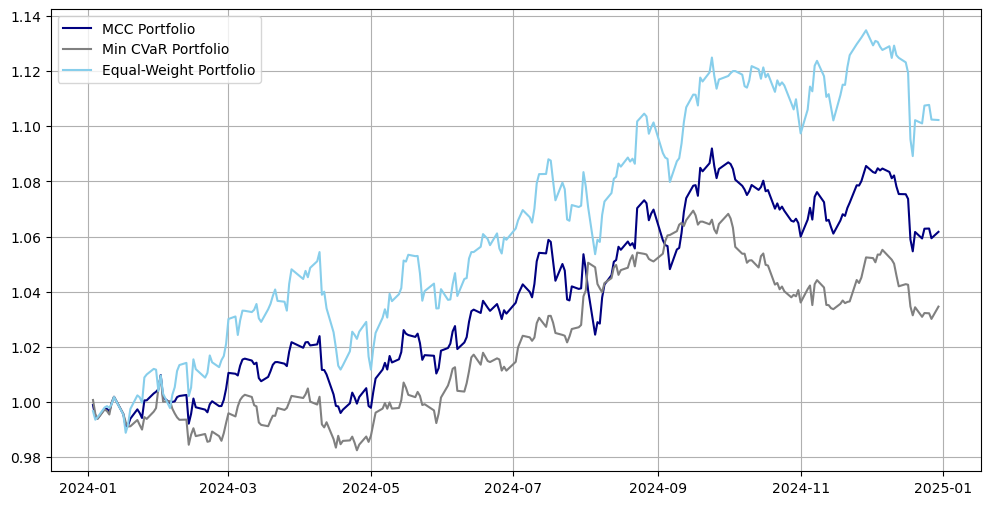

In [19]:
combined_returns_df = pd.concat([returns_df_q1, returns_df_q2, returns_df_q3, returns_df_q4])
cumulative_combined_returns_df = (1 + combined_returns_df).cumprod()

plt.figure(figsize=(12, 6))

plt.plot(cumulative_combined_returns_df['MCC Portfolio'], label='MCC Portfolio', c = 'navy')
plt.plot(cumulative_combined_returns_df['Min CVaR Portfolio'], label='Min CVaR Portfolio', c = 'gray')
plt.plot(cumulative_combined_returns_df['Equal-Weight Portfolio'], label='Equal-Weight Portfolio', c = 'skyblue')

plt.legend()
plt.grid();

In [20]:
summary_dynamic_df = pd.DataFrame({
    'Return (%)': (cumulative_combined_returns_df.iloc[-1] - 1) * 100,
        'Annualized Volatility (%)': combined_returns_df.std() * np.sqrt(252) * 100
})
summary_dynamic_df

,Return (%),Annualized Volatility (%)
MCC Portfolio,6.1686%,6.4208%
Min CVaR Portfolio,3.4566%,5.0654%
Equal-Weight Portfolio,10.2259%,7.9274%


## Results

In [21]:
mcc_weights_list = [mcc_weights_q1, mcc_weights_q2, mcc_weights_q3, mcc_weights_q4]
min_cvar_weights_list = [min_cvar_weights_q1, min_cvar_weights_q2, min_cvar_weights_q3, min_cvar_weights_q4]

mcc_weights_list_df = pd.DataFrame(mcc_weights_list, columns = returns.keys())
mcc_weights_list_df.index = ['Q1', 'Q2', 'Q3', 'Q4']

min_cvar_weights_list_df = pd.DataFrame(min_cvar_weights_list, columns = returns.keys())
min_cvar_weights_list_df.index = ['Q1', 'Q2', 'Q3', 'Q4']

ew_weights_df = pd.DataFrame([ew_weights] * 4, columns = returns.keys())
ew_weights_df.index = ['Q1', 'Q2', 'Q3', 'Q4']

min_cvar_weights_list_df = min_cvar_weights_list_df * 100
mcc_weights_list_df = mcc_weights_list_df * 100
ew_weights_df = ew_weights_df * 100

returns_list = [returns_q1_test, returns_q2_test, returns_q3_test, returns_q4_test]

mcc_cvar_pct_contributions_list = []
min_cvar_cvar_pct_contributions_list = []
ew_cvar_pct_contributions_list = []

for i in range(n_assets):
    mcc_cvar_contrubutions = individual_cvar_contributions(mcc_weights_list[i], returns_list[i], alpha)
    mcc_cvar = cvar(portfolio_return(returns_list[i], mcc_weights_list[i]), alpha)
    mcc_cvar_pct_contributions = mcc_cvar_contrubutions / mcc_cvar

    min_cvar_cvar_contrubutions = individual_cvar_contributions(min_cvar_weights_list[i], returns_list[i], alpha)
    min_cvar_cvar = cvar(portfolio_return(returns_list[i], min_cvar_weights_list[i]), alpha)
    min_cvar_cvar_pct_contributions = min_cvar_cvar_contrubutions / min_cvar_cvar

    ew_cvar_contrubutions = individual_cvar_contributions(ew_weights, returns_list[i], alpha)
    ew_cvar = cvar(portfolio_return(returns_list[i], ew_weights), alpha)
    ew_cvar_pct_contributions = ew_cvar_contrubutions / ew_cvar

    
    mcc_cvar_pct_contributions_list.append(mcc_cvar_pct_contributions)    
    min_cvar_cvar_pct_contributions_list.append(min_cvar_cvar_pct_contributions)
    ew_cvar_pct_contributions_list.append(ew_cvar_pct_contributions)

mcc_cvar_pct_contributions_df = pd.DataFrame(mcc_cvar_pct_contributions_list, columns = returns.keys())
mcc_cvar_pct_contributions_df.index = ['Q1', 'Q2', 'Q3', 'Q4']

min_cvar_cvar_pct_contributions_df = pd.DataFrame(min_cvar_cvar_pct_contributions_list, columns = returns.keys())
min_cvar_cvar_pct_contributions_df.index = ['Q1', 'Q2', 'Q3', 'Q4']

ew_cvar_pct_contributions_df = pd.DataFrame(ew_cvar_pct_contributions_list, columns = returns.keys())
ew_cvar_pct_contributions_df.index = ['Q1', 'Q2', 'Q3', 'Q4']

mcc_cvar_pct_contributions_df = mcc_cvar_pct_contributions_df * 100
min_cvar_cvar_pct_contributions_df = min_cvar_cvar_pct_contributions_df * 100
ew_cvar_pct_contributions_df = ew_cvar_pct_contributions_df * 100

In [24]:
display(Markdown('### MCC Portfolio Weights (%)'))
display(mcc_weights_list_df)
print()
display(Markdown('### MCC Portfolio CVaR percentage contribution (%)'))
display(mcc_cvar_pct_contributions_df)
print()
print()

display(Markdown('### Min CVaR Portfolio Weights (%)'))
display(min_cvar_weights_list_df)
print()
display(Markdown('### Min CVaR Portfolio CVaR percentage contribution (%)'))
display(min_cvar_cvar_pct_contributions_df)
print()
print()

display(Markdown('### Equal-Weight Portfolio Weights (%)'))
display(ew_weights_df)
print()
display(Markdown('### Equal-Weight Portfolio CVaR percentage contribution (%)'))
display(ew_cvar_pct_contributions_df)

### MCC Portfolio Weights (%)

Ticker,GSG,VBTLX,VNQ,VTI
Q1,12.0933%,66.0134%,10.1814%,11.7119%
Q2,12.4301%,64.5097%,10.3310%,12.7293%
Q3,25.9305%,25.9305%,22.3841%,25.7549%
Q4,12.1428%,64.9166%,10.1622%,12.7784%


### MCC Portfolio CVaR percentage contribution (%)

Ticker,GSG,VBTLX,VNQ,VTI
Q1,10.7558%,66.7896%,16.6989%,5.7557%
Q2,7.1893%,51.0137%,25.9962%,15.8008%
Q3,25.3392%,-1.1814%,22.9013%,52.9409%
Q4,5.3393%,52.4393%,28.2419%,13.9796%


### Min CVaR Portfolio Weights (%)

Ticker,GSG,VBTLX,VNQ,VTI
Q1,3.7399%,95.6289%,0.0000%,0.6311%
Q2,3.8126%,94.9498%,0.0000%,1.2376%
Q3,4.0431%,94.5603%,0.0000%,1.3966%
Q4,3.9979%,94.8483%,0.0000%,1.1538%


### Min CVaR Portfolio CVaR percentage contribution (%)

Ticker,GSG,VBTLX,VNQ,VTI
Q1,3.3134%,96.3776%,0.0000%,0.3090%
Q2,0.2917%,99.0644%,0.0000%,0.6439%
Q3,2.5291%,98.5392%,-0.0000%,-1.0683%
Q4,0.4638%,99.6856%,0.0000%,-0.1495%


### Equal-Weight Portfolio Weights (%)

Ticker,GSG,VBTLX,VNQ,VTI
Q1,25.0000%,25.0000%,25.0000%,25.0000%
Q2,25.0000%,25.0000%,25.0000%,25.0000%
Q3,25.0000%,25.0000%,25.0000%,25.0000%
Q4,25.0000%,25.0000%,25.0000%,25.0000%


### Equal-Weight Portfolio CVaR percentage contribution (%)

Ticker,GSG,VBTLX,VNQ,VTI
Q1,12.1522%,4.2272%,46.3976%,37.2230%
Q2,14.8000%,10.7244%,49.8154%,24.6601%
Q3,24.3671%,-1.1361%,25.5120%,51.2570%
Q4,20.1089%,13.6763%,44.9047%,21.3101%


In [23]:
display(Markdown('### Summary of Static Portfolios'))
display(summary_df)
print()
display(Markdown('### Summary of Dynamic Portfolios'))
display(summary_dynamic_df)

### Summary of Static Portfolios

,Return (%),Annualized Volatility (%)
MCC Portfolio,5.5455%,5.4313%
Min CVaR Portfolio,2.1365%,5.1340%
Equal-Weight Portfolio,9.9529%,7.8967%


### Summary of Dynamic Portfolios

,Return (%),Annualized Volatility (%)
MCC Portfolio,6.1686%,6.4208%
Min CVaR Portfolio,3.4566%,5.0654%
Equal-Weight Portfolio,10.2259%,7.9274%


The results show that all three strategies yield slightly higher returns when the portfolios are rebalanced, excluding any transaction costs. The MCC Portfolio approach offers a more effective risk allocation compared to the traditional Minimum CVaR Portfolio. While the Min CVaR Portfolio only focuses on minimizing the total portfolio CVaR, it can often make portfolios with too much risk exposure in specific assets.